# Standardized Precipitation Index (SPI)

The Standardized Precipitation Index (SPI) is the excess precipitation in a region compared to the historical average, divided by the variance of the historical average. The SPI indicates areas of statistically significant excess or deficit of precipitation. It is defined as

$SPI = \frac{P - P_\mu}{\sigma}$

Calculating the SPI requires aggregating years of historical data. We push this part of the analytics into a set of PAIRS queries that calculate averages and variances. Subsequently we obtain the SPI after a small amount of additional operations that are done locally.

References:
- https://climatedataguide.ucar.edu/climate-data/standardized-precipitation-index-spi
- http://www.wamis.org/agm/pubs/SPI/WMO_1090_EN.pdf
- https://journals.ametsoc.org/doi/10.1175/2009JCLI2909.1

In [1]:
from ibmpairs import paw, authentication
from datetime import datetime
import pandas as pd, numpy as np, os, matplotlib.pyplot as plt, matplotlib as mpl

We use our API key to authenticate. To do so, we generate an authentication object `pairs_credentials`. When using the `paw` library, this can be used directly when instantiating a query via `paw.PAIRSQuery`. However, when submitting an API request directly (via e.g. python's `requests` module), we need to use a suitable HTTP header. We construct this directly as well. See `pairs_auth_headers`.

**Please replace `<YOUR-PAIRS-API-KEY>` with your PAIRS API key.**

In [2]:
PAIRS_API_KEY = '<YOUR-PAIRS-API-KEY>'
PAIRS_SERVER   = 'https://pairs.res.ibm.com'
PAIRS_CREDENTIALS = authentication.OAuth2(api_key = PAIRS_API_KEY)

This next line converts datetime objects to strings in ISO 8601-compliant format:

In [3]:
iso8601 = "%Y-%m-%dT%H:%M:%SZ"

## Calculating the SPI with PAIRS

### Querying the data

We use a *user defined functin* (UDF) to push the aggregations necessary for calculating the SPI into the PAIRS query. As usual, it is best to write a function that generates the UDF instead of writing it by hand. This is done by `getPAIRSQueries`.

Inputs are the start and end years for determinig averages as well as the year and month for the SPI (`month` and `year_spi`). To construct the queries, the function loops over year assembling a list of layers (`layerList`) to be queried. Each layer has the alias of "r" plus the year name. It contains the aggregated sum of the hourly precipitation amounts for that month. The precipitation comes from the dataset `49459`, which contains the total precipitation values according to the ERA5 climate reanalysis.

These are the ingredients for three expressions:
- The historic average monthly precipitation for the month in question (`"alias" : "ave"`).
- The historic average of the squares of monthly precipitation totals (`"alias" : "ave2"`).
- The calculation of the variance for the month in question from the above (`"alias" : "var"`).

In [4]:
def getPAIRSQueries(month, year_spi = 2018, year_start = 2009, year_end = 2017, spatial_coverage = {"type" : "poly", "aoi" : "38301"}):
    '''
    Generates the query JSONs used to calculate the SPI in IBM PAIRS Geoscope.
    '''
    
    if(month!=12):
        end_spi = datetime(year_spi, month+1, 1).strftime(iso8601)
    else:
        end_spi = datetime(year_spi+1, 1, 1).strftime(iso8601)
        
    layerList = list()
    for year in range(year_start, year_end + 1, 1):
        
        if(month!=12):
            end_str = datetime(year, month+1, 1).strftime(iso8601)
        else:
            end_str = datetime(year+1, 1, 1).strftime(iso8601)
            
        layer_year = {
                 "alias" : "r" + str(year), "type" : "raster", "id" : "49459",
                 "aggregation" : "Sum",
                 "temporal" : { "intervals" : [{
                         "start" : datetime(year, month, 1).strftime(iso8601),
                         "end" : end_str }]},
                 "output" : False}
        # append list
        layerList.append(layer_year)

    # 1st UDF: average
    average_udf = dict()
    average_udf["alias"] = "ave"
    average_udf["expression"] = None

    # create 'expression' value automatically 
    str_avg = "("
    for year in range(year_start, year_end + 1, 1):
        str_avg += '$r' + str(year) + '+'
    # - cut last '+' sign     
    str_avg = str_avg[0:len(str_avg)-1]
    # - add the denominator
    str_avg += ')/(' + str(year_end) + '-' + str(year_start) + '+1)'

    average_udf["expression"] = str_avg

    # 2nd UDF: average of squared values
    average2_udf = dict()
    average2_udf["alias"] = "ave2"
    average2_udf["expression"] = None

    # create 'expression' value automatically 
    str_avg2 = "("
    for year in range(year_start, year_end + 1, 1):
        str_avg2 += '$r' + str(year) + '*' + '$r' + str(year) + '+'
    # - cut last '+' sign     
    str_avg2 = str_avg2[0:len(str_avg2)-1]
    # - add the denominator
    str_avg2 += ')/(' + str(year_end) + '-' + str(year_start) + '+1)'

    average2_udf["expression"] = str_avg2
    
    # UDF for variance
    variance_udf = {"alias" : "var", "expression" : "math:sqrt($ave2-$ave*$ave)"}

    # append
    layerList.append(average_udf)
    layerList.append(average2_udf)
    layerList.append(variance_udf)

    queryJson = dict()
    queryJson = {"layers" : layerList,
        "spatial" : spatial_coverage,
        "temporal" : {"intervals" : [{"snapshot" : "2018-05-31T00:00:00Z"}]}
    }
    
    alias_str = 'r' + str(year_spi) 
    queryJson2 = {
        "layers" : [ 
            {
                "alias" : alias_str, "type" : "raster", "id" : "49459",
                "aggregation" : "Sum",
                "temporal" : { "intervals" : [{
                        "start" : datetime(year_spi, month, 1).strftime(iso8601),
                        "end" : end_spi }]},
                "output" : True
            },
        ],
        "spatial" : spatial_coverage,
        "temporal" : {"intervals" : [{"snapshot" : "2018-05-31T00:00:00Z"}]}
    }
    
    return queryJson, queryJson2

In [5]:
month, year_spi = 2, 2018
queryJson, queryJson2 = getPAIRSQueries(month = month, year_spi = year_spi)

To submit the queries to PAIRS, we wrap the above JSONs in `paw.PAIRSQuery` objects.

In [6]:
query = paw.PAIRSQuery(queryJson, PAIRS_SERVER, PAIRS_CREDENTIALS, authType='api-key')
query2 = paw.PAIRSQuery(queryJson2, PAIRS_SERVER, PAIRS_CREDENTIALS, authType='api-key')

In [7]:
query.submit()
query2.submit()

In [8]:
query.poll_till_finished()
query2.poll_till_finished()
query.download()
query2.download()
query.create_layers()
query2.create_layers()

### Local calculations and visualizting the result

In the following various expressions are made to do the arithmetic, which is the difference between the precipitation in the desired year and the past average for that month, divided by the variance for that month. The results are plotted at the end of the loop over each month. The color range for each plot is determined by the rms of the plotted quantity.

precip= 0.09007392133029594 0.11366360289804692 -0.023589681567750972 0.20373752422834285
ave= 0.08733205859039479 0.10471808266233214 -0.017386024071937345 0.19205014125272693
var= 0.027558691230311627 0.026364900514834134 0.0011937907154774934 0.05392359174514576
 diff= 0.0007860483481229778 0.030001981044007905 -0.029215932695884926 0.030788029392130885
pci= 0.07634829472646774 0.9204902379508698 -0.8441419432244021 0.9968385326773376


/var/folders/3r/xk0bclms4pxfcxq5wkvx2s4h0000kp/T/ipykernel_41651/908087621.py:40: MatplotlibDeprecationWarning: Passing the sharex parameter of subplots() positionally is deprecated since Matplotlib 3.3; the parameter will become keyword-only two minor releases later.
  fig, axes = plt.subplots(2,2, True, True, figsize = (12, 12))


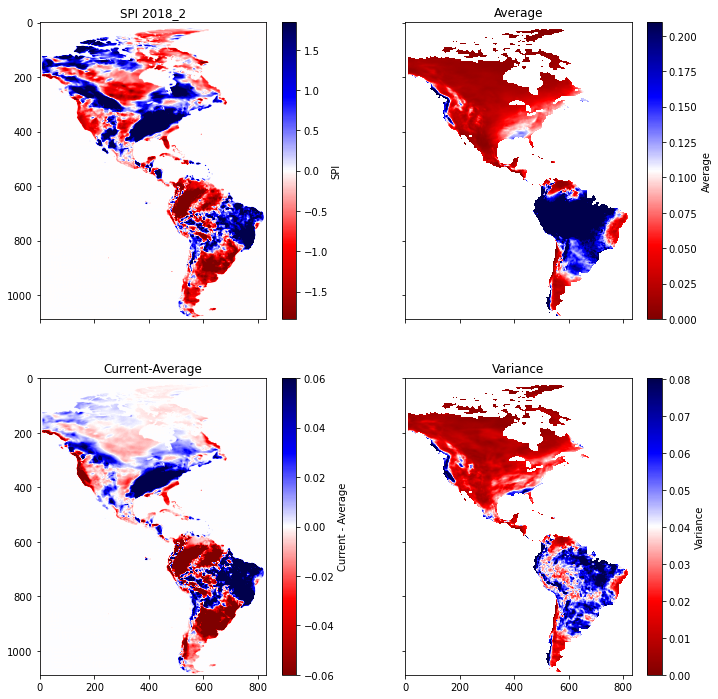

In [9]:
alias_str = 'r' + str(year_spi) 
a_str = 'Global weather (ERA5)-Total precipitation[' + alias_str + ']-Sum'
a=query2.data[a_str]
b=query.data['Expression-ave[ave]-Exp']
c=query.data['Expression-var[var]-Exp']
c1 = np.array(c) 
c1[np.isnan(c)]=0
ab = np.array(a-b)
ab[np.isnan(a-b)]=0
minvar=np.nanmin(query.data['Expression-var[var]-Exp'])
#print(minvar)
c2=c1*ab/((0.5*minvar+c1)*(0.5*minvar+c1))  # this is ab/c1 but avoiding divide by zero
amean=np.nanmean(a)
arms=np.nanstd(a)
print('precip=',amean,arms,amean-arms,amean+arms)
#print(a.shape)
bmean=np.nanmean(b)
brms=np.nanstd(b)
print('ave=',bmean,brms,bmean-brms,bmean+brms)
#print(b.shape)
varmean=np.nanmean(c)
varrms=np.nanstd(c)
print('var=',varmean,varrms,varmean-varrms,varmean+varrms)
#print(c.shape)
abmean=np.nanmean(ab)
abrms=np.nanstd(ab)
print(' diff=',abmean,abrms,abmean-abrms,abmean+abrms)
#print(ab.shape)
c2mean=np.nanmean(c2)
c2rms=np.nanstd(c2)
print('pci=',c2mean,c2rms,c2mean-c2rms,c2mean+c2rms)
#print(c2.shape)
# use these next few lines to make a figure with just the SPI
#    plt.figure(figsize = (16, 12))
#    plt.imshow(c2, vmin=-2*c2rms, vmax=+2*c2rms, cmap = 'seismic_r')
#    plt.colorbar()
#    str_title = "SPI_" + str(year_spi) + "_" + str(month) + "_" + "Americas.png"
#    plt.savefig(str_title , transparent=True, bbox_inches = 'tight')
#    plt.show()
fig, axes = plt.subplots(2,2, True, True, figsize = (12, 12))
axesImage1 = axes[0, 0].imshow(c2, cmap = 'seismic_r', vmin = -2*c2rms, vmax = 2*c2rms)
axesImage2 = axes[0, 1].imshow(b, cmap = 'seismic_r', vmin=0, vmax=2*brms)
axesImage3 = axes[1, 0].imshow(ab, cmap = 'seismic_r', vmin=-2*abrms, vmax=2*abrms)
axesImage4 = axes[1, 1].imshow(c, cmap = 'seismic_r', vmin=0, vmax=varmean+2*varrms)
axes[0, 0].set_title('SPI '+str(year_spi)+"_"+str(month))
axes[0, 1].set_title('Average')
axes[1, 0].set_title('Current-Average')
axes[1, 1].set_title('Variance')
plt.colorbar(axesImage1, ax = axes[0,0], label = 'SPI')
plt.colorbar(axesImage2, ax = axes[0,1], label = 'Average')
plt.colorbar(axesImage3, ax = axes[1,0], label = 'Current - Average')
plt.colorbar(axesImage4, ax = axes[1,1], label = 'Variance')
str_title = "SPI_" + str(year_spi) + "_" + str(month) + "_" + "America.png"
plt.savefig(str_title , transparent=True, bbox_inches = 'tight')
plt.show()